In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io


In [2]:
import torch

In [3]:
from timeit import default_timer as timer
import sklearn.datasets

In [195]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=50000,
                                            n_informative=5,
                                            n_redundant=30000,
                                            n_repeated=0,
                                            class_sep=0.5,
                                            n_classes=n_classes,
                                            random_state = 4)

n_features = X.shape[1]

In [196]:
# transform labels
y = np.where(y == 0, -1, y)

In [6]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io

url_x = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy'
url_y = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [179]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [180]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 800 200


# Clipping and Gradient definition

In [181]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [182]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients
#     clipped_grads = L2_clip_array(gradients, C)
#     return np.sum(clipped_grads, axis = 0)

In [183]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# Baseline (gradient clipping DP-SGD)

In [197]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            norms           = np.linalg.norm(grads, ord=2, axis=1)
            print('avg norm:', np.mean(norms, axis=0))
            
            clipped_grads   = L2_clip_array(grads, clipping_param)
            avg_grad        = np.mean(clipped_grads, axis=0)
            noisy_grad      = gaussian_mech_zCDP_vec(avg_grad, clipping_param/len(xs), rho_i)
            theta           = theta - noisy_grad

    return theta

In [198]:
rho = 1
epochs = 5
#print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

avg norm: 165.76830408426738
avg norm: 90.88449542628645
avg norm: 109.54410138452893
avg norm: 96.85951237930549
avg norm: 81.01347696041167
avg norm: 80.06845349203269
avg norm: 84.98295801483356
avg norm: 108.97922393263642
avg norm: 145.506743419262
avg norm: 104.61269940152182
avg norm: 72.387532799153
avg norm: 76.12812766780584
avg norm: 79.72880173176249
avg norm: 81.26744833946174
avg norm: 91.28986438527032
avg norm: 165.76830408426738
avg norm: 90.66983439731025
avg norm: 95.07896181444829
avg norm: 88.1440773422198
avg norm: 80.78207109879898
avg norm: 79.86185761004967
avg norm: 90.37859844732678
avg norm: 111.60490772843438
avg norm: 136.36616411943393
avg norm: 99.71995620735629
avg norm: 77.90439401191327
avg norm: 82.15980226725206
avg norm: 94.3916940335519
avg norm: 111.12666613781177
avg norm: 122.45116709342793
avg norm: 165.76830408426738
avg norm: 96.4643048059498
avg norm: 105.29608996153434
avg norm: 93.10052395220217
avg norm: 80.04018544032965
avg norm: 83.03

# SignSGD + dimensionality reduction

In [22]:
# exponential mechanism, k times
# sat rho-zCDP
def top_k(grads, C, k, rho):
    rho_i = rho / k
    clipped_grads = np.clip(grads, -C, C)
    avg_grad = np.mean(clipped_grads, axis=0)
    sens = C / len(grads)
    noise = np.random.gumbel(loc=0, scale=sens/np.sqrt(8*rho_i), size=len(avg_grad))
    noisy_scores = avg_grad + noise
    k_ind = np.argpartition(noisy_scores, -k)[-k:]
    return k_ind

In [23]:
def dp_gradient_descent(epochs, rho, k=20, clipping_param=.3):
    rho_i = rho/epochs
    d = X_train.shape[1]
    theta = np.zeros(d)                 # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            
            # this is not private yet
            k_ind_old       = np.argpartition(np.abs(np.mean(grads, axis=0)), -k)[-k:]
            k_ind           = top_k(grads, clipping_param, k, .1*rho_i)
            k_grads         = grads[:, k_ind]
            #print('old k_ind:', k_ind_old, 'new k_ind:', k_ind)
            
            # clip just the chosen parameters
            clipped_grads   = L2_clip_array(k_grads, clipping_param)
            avg_grad        = np.mean(clipped_grads, axis=0) # sensitivity is clipping_param / len(xs)
            noisy_grad      = gaussian_mech_zCDP_vec(avg_grad, clipping_param/len(xs), .9*rho_i)
            full_grad       = np.zeros(d)
            full_grad[k_ind]= noisy_grad
            #print(full_grad)
            theta           = theta - full_grad       # regular version
            #theta            = theta - (.5/(i+5))*np.sign(full_grad)     # sign version

    return theta

In [24]:
def dp_gradient_descent(epochs, rho, k=20, clipping_param=.3):
    rho_i = rho/epochs
    d = X_train.shape[1]
    theta = np.zeros(d)                 # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):
        eta = (.5/(i+10))
        #print('rate:', eta)

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            k_ind_pos       = top_k(grads, clipping_param, k, .5*rho_i)
            k_ind_neg       = top_k(-grads, clipping_param, k, .5*rho_i)
            full_grad       = np.zeros(d)
            
#             print('num rate', .01*rate)
#             print('analytic rate', (.5 / (i+5)))

            full_grad[k_ind_pos] = 1
            full_grad[k_ind_neg] = -1

            theta            = theta - eta*full_grad     # sign version
            #theta            = theta - *rate*full_grad     # sign version
    return theta

In [199]:
def dp_gradient_descent(epochs, rho, k=100, clipping_param=.3):
    rho_i = rho/epochs
    d = X_train.shape[1]
    theta = np.zeros(d)                 # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):
        eta = (.5/(i+10))
        #print('rate:', eta)

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            top_k           = np.argpartition(np.abs(grads), -k, axis=1)[:, -k:]
            full_grad       = np.zeros(grads.shape)
            important_grads = np.take_along_axis(grads, top_k, 1)
            
            np.put_along_axis(full_grad, top_k, important_grads, 1)
            norms           = np.linalg.norm(full_grad, ord=2, axis=1)
            print('avg norm:', np.mean(norms, axis=0))
            
            clipped_grad    = L2_clip_array(full_grad, clipping_param)
            avg_grad        = np.mean(clipped_grad, axis=0)
            noisy_grad      = gaussian_mech_zCDP_vec(avg_grad, clipping_param/len(xs), rho_i)

            theta            = theta - noisy_grad     # sign version
            #theta            = theta - *rate*full_grad     # sign version
    return theta

In [201]:
rho = 1
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho, k=500, clipping_param=1)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 7.786140424415112
avg norm: 47.25118814241032
avg norm: 26.458637732419607
avg norm: 28.617925991307857
avg norm: 29.961640377792964
avg norm: 24.577146272866436
avg norm: 25.357136968362962
avg norm: 24.064754685601137
avg norm: 25.492538329521217
avg norm: 28.14994021986853
avg norm: 27.942097066054007
avg norm: 26.4306785467896
avg norm: 27.728974290880373
avg norm: 24.30832776235286
avg norm: 23.947667707551542
avg norm: 27.085705315150335
avg norm: 47.25118814241032
avg norm: 33.64293930306714
avg norm: 25.503273105951802
avg norm: 25.42005519752407
avg norm: 22.803101231252455
avg norm: 26.915299275115604
avg norm: 25.645136292241087
avg norm: 23.74085421612362
avg norm: 24.8305830638454
avg norm: 24.46930674211356
avg norm: 24.832370654104253
avg norm: 26.70195239917906
avg norm: 28.64481757351941
avg norm: 27.50754779976543
avg norm: 24.424315931676873
avg norm: 47.25118814241032
avg norm: 32.83984444076289
avg norm: 25.77006777465066
avg norm: 26.743111994913246
avg norm:

In [99]:
rho = .1
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho, k=50, clipping_param=.1)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 2.2459660262893473
grad shape: (334, 10000)
top_k shape: (334, 50)
trimmed grads shape: (334, 10000)
shape of indx: (334, 50)
(334, 10000)


ZeroDivisionError: division by zero

In [ ]:
ks = [1, 10, 20, 50, 70, 100]
ks = np.linspace(10, 80, 40)
runs = 20
means = []
stds = []
for k in ks:
    print(k)
    accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(runs)]
    means.append(np.mean(accs))
    stds.append(np.std(accs))

<ErrorbarContainer object of 3 artists>

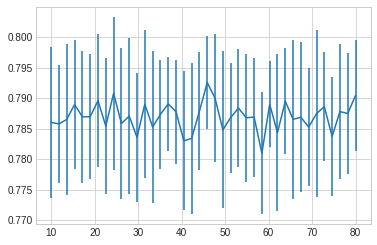

In [211]:
plt.errorbar(ks, means, yerr=stds)